In [211]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [306]:
# M = np.random.rand(3, 3, 3)
# M -= M[1, 1, 1]
M = np.fromfunction(lambda i, j, k: np.exp(-(i-1.1)**2) + np.exp(-(j-1)**2) +(-np.exp(-(k-1)**2)), (3, 3, 3))
M -= M[1, 1, 1]

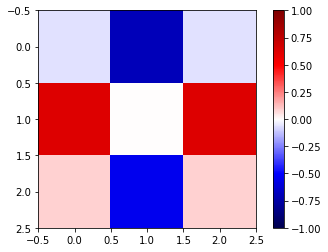

In [307]:
plt.imshow(M[:, 1], vmin=-1, vmax=1, cmap='seismic')
plt.colorbar()

We will try to create a 2nd order polynomial to fit M
$$
P(x, y, z) = \sum_{0 \leq i+j+k\leq 2} a_{i,j,k}x^iy^jz^k
$$

In [308]:
xx = [-1, 0, 1]
X, Y, Z = np.meshgrid(xx, xx, xx, indexing='ij')
X2 = X**2
Y2 = Y**2
Z2 = Z**2

Let's not $A$ the array of the 9 coefficients (we skip the constant value as it is equal to the central value of $M$) and $B$ be the coefficients of the gradient of $P$.

We want the polynomial to fit the value of $M$ at the 6 faces of the central value. Let
$$
X = (x^2, y^2, z^2, xy, xz, yz, x, y, z)^\text{T},
$$
$$ A = (a_{xx}, a_{yy}, a_{zz}, a_{xy}, a_{xz}, a_{yz}, a_{x}, a_y, a_z).$$

Let's number the indices of the 6 direct neighbors of the center cell and call $M'$ the value of $M$ in these cells ($M$ has shape `(6,)`).
Let's write $M_h = \nabla_i\nabla_j M$ with $i<j$ _at the center cell_.

Let
$$
\left\{\begin{matrix}
XX_I = (X_I, 1_7, 1_{8}, 1_{9}), \\
MM = (M_I, M_h).
\end{matrix}\right.
$$
Here we have used ${}_I$ to denote the index of the $i$-th direct neighbor cell. $A$ has shape $(9,)$, $XX$ $(9, 9)$ and $MM$ $(9, )$. We have also used the notation $1_i$ for an empty vector of size $9$ with the $i$-th value set to $1$.

Solving for the polynomical is the same as solving the linear problem
$$
AA\cdot XX = MM.
$$

In [310]:
indexes = np.zeros((6, 3), dtype=int)
l = 0
for i in [-1, 0, 1]:
    for j in [-1, 0, 1]:
        for k in [-1, 0, 1]:
            tmp = np.array([i, j, k])
            # Only keep direct neighbors
            if (tmp == 0).sum() == 2:
                indexes[l, :] = tmp
                l += 1

Building $MM$

In [311]:
import itertools
MM = np.empty(9)
MM[:6] = M[I, J, K]
Mh = np.zeros(3)
for l, (i, j) in enumerate(itertools.combinations(range(3), 2)):
    Mh[l] = np.diff(np.diff(M, axis=j), axis=i).mean()
    
MM[6:] = Mh

In [312]:
MM

array([-0.54519177, -0.69185255, -0.69185255, -1.32397311, -0.059732  ,
        0.        ,  0.        ,  0.        ,  0.        ])

Building $XX$

In [313]:
XX = np.zeros((9, 9))
XX[:, :6] = np.array([X2[I, J, K], Y2[I, J, K], Z2[I, J, K],
                      X[I, J, K], Y[I, J, K], Z[I, J, K],
                      (X*Y)[I, J, K], (X*Z)[I, J, K], (Y*Z)[I, J, K]])
for i in range(6, 9):
    XX[i, i] = 1

In [354]:
XX

array([[ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.],
       [-1.,  1., -1., -1.,  0., -1.,  0.,  0.,  0.],
       [-1., -1.,  1.,  0., -1., -1.,  0.,  0.,  0.],
       [-1., -1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.],
       [-1.,  1., -1.,  0.,  1.,  0.,  0.,  1.,  0.],
       [ 1., -1., -1.,  0.,  0.,  1.,  0.,  0.,  1.]])

In [356]:
I, J, K

(array([-1,  0,  0,  0,  0,  1]),
 array([ 0, -1,  0,  0,  1,  0]),
 array([ 0,  0, -1,  1,  0,  0]))

In [355]:
print('''[[ 1.  1.  1.  1.  1.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.  1.  0.  0.  0.]
 [ 1.  1.  1.  0.  1.  1.  0.  0.  0.]
 [ 1. -1. -1. -1. -1.  0.  0.  0.  0.]
 [-1.  1. -1. -1.  0. -1.  0.  0.  0.]
 [-1. -1.  1.  0. -1. -1.  0.  0.  0.]
 [-1. -1.  1.  1. -0. -0.  1.  0.  0.]
 [-0. -0.  0.  0. -0. -0.  0.  1.  0.]
 [ 1. -1. -1. -0. -0.  1.  0.  0.  1.]]''')


[[ 1.  1.  1.  1.  1.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.  1.  0.  0.  0.]
 [ 1.  1.  1.  0.  1.  1.  0.  0.  0.]
 [ 1. -1. -1. -1. -1.  0.  0.  0.  0.]
 [-1.  1. -1. -1.  0. -1.  0.  0.  0.]
 [-1. -1.  1.  0. -1. -1.  0.  0.  0.]
 [-1. -1.  1.  1. -0. -0.  1.  0.  0.]
 [-0. -0.  0.  0. -0. -0.  0.  1.  0.]
 [ 1. -1. -1. -0. -0.  1.  0.  0.  1.]]


In [331]:
A = np.linalg.solve(XX.T, MM)

In [332]:
A

array([-0.61852216, -0.63212056,  0.63212056,  0.07333039,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [340]:
MM @ np.linalg.inv(XX)

array([-0.61852216, -0.63212056,  0.63212056,  0.07333039,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [316]:
np.allclose((A @ XX)[:-3], M[I, J, K])

True

We now have the coefficients of the polynomial $P$. The coefficients of its derivative are
$$
\frac{\partial P}{\partial x}(x, y, z) = \sum_{0\leq i+j+k\leq 2} i\ a_{i,j,k} x^{i-1}y^jz^k.
$$
Imposing a zero gradient then yields
$$
\left\{\begin{matrix}
2\ a_{200} x + a_{110}y + a_{101}z + a_{100} &= 0\\
2\ a_{020} y + a_{110}x + a_{011}z + a_{010} &= 0\\
2\ a_{002} z + a_{101}x + a_{011}y + a_{001} &= 0
\end{matrix}\right.
$$
which is the same as solving
$$
AA\cdot X = -(a_{100}, a_{010}, a_{001})^\text{T},
$$
with
$$
AA = \left(\begin{matrix}
2a_{200} & a_{110} & a_{101} \\
a_{110} & 2a_{020} & a_{011} \\
a_{101} & a_{011} & 2a_{002}
\end{matrix}\right)
$$

In [319]:
AA_order = np.array([[0, 6, 7],
                     [6, 1, 8],
                     [7, 8, 2]])
AA_factor = np.array([[2, 1, 1],
                      [1, 2, 1],
                      [1, 1, 2]])
AA = A[AA_order.flatten()].reshape(3, 3) * AA_factor
rhs = -A[[3, 4, 5]].T
AAinv = np.linalg.inv(AA)

It is easy to show that (this is exact for a polynomial of degree 2)
$$
\nabla P = \Delta X \nabla\nabla P,
$$
so
$$
\Delta X = \left.\nabla P\right|_0 \left(\nabla\nabla P|_0\right)^{-1}
$$

In [328]:
xyz = AAinv @ rhs

In [329]:
xyz

array([0.05927871, 0.        , 0.        ])

We now have the point where the gradient is null, the hessian matrix is actually $AA$!

In [330]:
eigvals = np.linalg.eigvalsh(AA)
eigvals

array([-1.26424112, -1.23704432,  1.26424112])